[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/cnn/cnn_architecture.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# CNN for image classification

We now see a common architecture followed in Convolutional Neural Networks (CNNs) for image classification tasks:
- Different convolutional layers, using ReLU as the activation function.
- Followed by pooling layers to reduce its memory requirements.
- To perform the classification, the output of the CNN is passed to a dense layers.

<img src="img/cnns.png" width="600px"/>

Whit this architecture, it is very common that the size of the images / feature maps get smaller and smaller. Similarly, feature maps get deeper and deeper. 

In [1]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/cnn'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/img/* img/.

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Data preparation

We use the [fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset from keras. This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

In [2]:
# We download fashion MNIST the dataset from keras.
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist

# We change the shape of X_train_full from (60k, 28, 28) to (60k, 28, 28, 1)
# This is because the images have only one channel (gray color), but we want to apply convolutional
# layers the same way as we do for multichannel images (color images)
X_train_full = np.expand_dims(X_train_full, axis=-1)
# We re-scale the gray color to a number between 0 and 1
X_train_full = X_train_full.astype(np.float32) / 255
# We do the same with the test set
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255

# We split the full training set into a training set and a validation set
N_VAL_INSTANCES = 10_000
X_train, X_val = X_train_full[:-N_VAL_INSTANCES], X_train_full[-N_VAL_INSTANCES:]
y_train, y_val = y_train_full[:-N_VAL_INSTANCES], y_train_full[-N_VAL_INSTANCES:]

# Show shapes of all the datasets
print(f"Shape of X_train = {X_train.shape} and y_train = {y_train.shape}.")
print(f"Shape of X_val = {X_val.shape} and y_val = {y_val.shape}.")
print(f"Shape of X_test = {X_test.shape} and y_test = {y_test.shape}.")

Shape of X_train = (50000, 28, 28, 1) and y_train = (50000,).
Shape of X_val = (10000, 28, 28, 1) and y_val = (10000,).
Shape of X_test = (10000, 28, 28, 1) and y_test = (10000,).


## CNN model

We create the convolutional neural network model using the Keras API. We use the following layers:
- `Conv2D`: Convolutional layer with different filters, with padding, ReLU activation function, and he_normal kernel initializer (works well with ReLU).
- `MaxPool2D`: Pooling layer to reduce the size of the feature maps and hence the memory requirements.
- `Flatten`: Layer to flatten the feature maps into a vector that can be passed to a dense layer for classification.
- `Dense`: Fully connected layer with ReLU activation function and he_normal kernel initializer, acting as hidden layers in a MLP.
- `Dropout`: Regularization mechanism to reduce overfitting. Dropout randomly sets a fraction of the input units (0.5=50% in our case) to 0 at each update during training time, which helps prevent overfitting.

Notice that the output layer has 10 units (one per class) and uses the softmax activation function.

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=[28, 28, 1], kernel_size=7, filters=64, padding="same", activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding="same", activation="relu", kernel_initializer="he_normal"), 
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding="same", activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding="same", activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding="same", activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    # Regularization mechanism to reduce overfitting
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    # We have 10 possible outputs (softmax)
    tf.keras.layers.Dense(units=10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

The CNN has more than 1.4 million parameters!

## Model training

We train the model using for 10 epochs, using the NAdam optimizer (a variant of Adam), and sparse categorical cross-entropy as the loss function (multiclass classification with an ordinal value as output).

Epoch 1/10
1563/1563 [==============================] - 141s 87ms/step - loss: 0.7652 - accuracy: 0.7344 - val_loss: 0.3612 - val_accuracy: 0.8675
Epoch 2/10
1563/1563 [==============================] - 139s 89ms/step - loss: 0.4305 - accuracy: 0.8546 - val_loss: 0.3133 - val_accuracy: 0.8880
Epoch 3/10
1563/1563 [==============================] - 137s 88ms/step - loss: 0.3633 - accuracy: 0.8800 - val_loss: 0.2879 - val_accuracy: 0.8901
Epoch 4/10
1563/1563 [==============================] - 139s 89ms/step - loss: 0.3234 - accuracy: 0.8910 - val_loss: 0.2762 - val_accuracy: 0.9025
Epoch 5/10
1563/1563 [==============================] - 136s 87ms/step - loss: 0.2936 - accuracy: 0.9013 - val_loss: 0.2580 - val_accuracy: 0.9062
Epoch 6/10
1563/1563 [==============================] - 129s 83ms/step - loss: 0.2748 - accuracy: 0.9071 - val_loss: 0.2686 - val_accuracy: 0.9049
Epoch 7/10
1563/1563 [==============================] - 137s 88ms/step - loss: 0.2578 - accuracy: 0.9112 - val_loss: 0

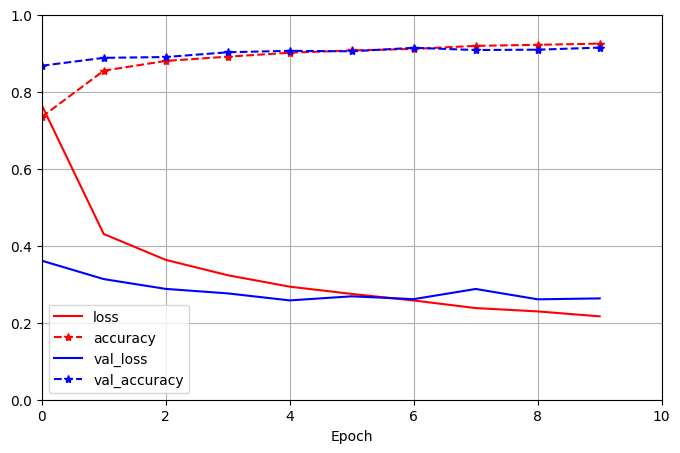

In [4]:
EPOCHS = 10
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# Let's take a look at how test and train loss and accuracy evolved during training
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, EPOCHS], ylim=[0, 1], grid=True, xlabel="Epoch",
    # red/blue, dashed(--), continuous (-), shape(. or *)
    style=["r-", "r--*", "b-", "b--*"])  # train-loss=red(-), train-accuracy=red(--*), val_loss=blue(-), val_accuracy=blue(--*)
plt.show()

## Evaluation

Let's evaluate the model with the test dataset.

In [6]:
evaluation_results = model.evaluate(X_test, y_test)
print(f"Test loss: {evaluation_results[0]:.4f}. Test accuracy: {evaluation_results[1]:.4f}.")

313/313 [==============================] - 7s 22ms/step - loss: 0.2796 - accuracy: 0.9073
Test loss: 0.2796. Test accuracy: 0.9073.


In an example execution, the following values were obtained:
- Val loss: 0.2632. Val accuracy: 0.9146.
- Test loss: 0.2796. Test accuracy: 0.9073.

These values are significantly better than the ones obtained with the MLP in `activation/image_classifier.ipynb` (266.6K parameters):
- Test loss: 0.3532. Test accuracy: 0.8716.

## ✨ Questions ✨ 

1. What do you think it is causing this improvement?
2. Do you think an MLP with 1.4 million parameters would perform similarly?

### Answers

*Write your answers here.*

